# Publication-Ready Visualization Framework for Medical Image Segmentation

This notebook provides a flexible framework to generate publication-ready figures for comparing multiple segmentation models on medical imaging data (e.g., CT or MR). It supports overlaying ground truth, model predictions, probability maps, and uncertainty maps, and is designed to produce figures similar to those in high-impact publications.

## Required Libraries

This framework uses the following Python libraries:
- `nibabel` for loading NIfTI images (`.nii.gz`)
- `numpy` for array manipulation
- `matplotlib` for figure creation and publication-quality visualization
- `seaborn` for color palettes
- `scikit-image` for image processing (optional, for overlays)

Install them with:
```bash
pip install nibabel numpy matplotlib seaborn scikit-image
```

In [1]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import exposure
from matplotlib.patches import Patch
import matplotlib.colors as mcolors
from nnunetv2.paths import nnUNet_raw, nnUNet_results
from batchgenerators.utilities.file_and_folder_operations import join, isdir, listdir, maybe_mkdir_p
import re

# Set matplotlib for publication quality
plt.rcParams.update({'font.size': 14, 'figure.dpi': 150, 'savefig.bbox': 'tight'})

In [2]:
def find_cases(dir_path):
        cases = listdir(dir_path)
        cases = [case for case in cases if re.match(r'case_\d+', case)]
        return cases

## Input Structure

You will need to provide the filepaths for:
- CT/MR images (`.nii.gz`)
- Ground truth segmentations
- Model predictions (for each model)
- Probability maps (optional, for each model)
- Uncertainty maps (optional, for each model)

**Instructions:**
1. Fill in the lists below with your filepaths for each case and model.
2. Run the notebook to generate the figure.

In [49]:
# --- USER INPUT SECTION ---

dataset = 'Dataset003_ImageCAS_split'





# List of model names (order will be used in the figure)
model_names = [
    "base", "tta", "ens", "mcd", "tta_ens", "tta_mcd", "ens_mcd", "all"
]

model_paths = [join('nnUNetTrainerDropout__p00_s2__3d_fullres', model_name) if model_name in ['base', 'tta', 'ens', 'tta_ens'] else join('nnUNetTrainerDropout__p02_s2__3d_fullres', model_name) for model_name in model_names]

cases = find_cases(join(nnUNet_results, dataset, model_paths[0]))  # Assuming all models have the same cases

case = cases[0]  # Select the first case for demonstration

case = 'case_0002'

# Example: one case, 8 models
image_path = join(nnUNet_raw, dataset, 'imagesTs', f'{case}_0000.nii.gz')
gt_path = join(nnUNet_raw, dataset, 'labelsTs', f'{case}.nii.gz')

# For each model, provide prediction, probability, and uncertainty map paths
model_pred_paths = [join(nnUNet_results, dataset, model_path, case, f'{case}_seg.nii.gz') for model_path in model_paths]
model_prob_paths = [join(nnUNet_results, dataset, model_path, case, f'{case}_foreground.nii.gz') for model_path in model_paths]
model_uncertainty_paths = [join(nnUNet_results, dataset, model_path, case, f'{case}_shannon_entropy.nii.gz') for model_path in model_paths]

# Set to None if not available


In [4]:
def load_nii(path):
    img = nib.load(path)
    data = img.get_fdata()
    # Rotate volume 90° anticlockwise
    data = np.rot90(data, k=1, axes=(0, 1))
    return data

def normalize_image(img, pmin=0, pmax=100):
    vmin, vmax = np.percentile(img, [pmin, pmax])
    img = np.clip(img, vmin, vmax)
    img = (img - vmin) / (vmax - vmin)
    return img

In [5]:
# Define class labels and colors (edit as needed for your dataset)
class_labels = ['Segmentation']

class_colors = [
    '#FFD700', '#90EE90', '#1E90FF', '#FFA500', '#40E0D0', '#DA70D6', '#FFB6C1'
]
label2color = {i+1: c for i, c in enumerate(class_colors)}  # assuming 0 is background
legend_patches = [Patch(color=c, label=l) for l, c in zip(class_labels, class_colors)]

In [6]:
def overlay_segmentation(image, seg, alpha=0.5):
    rgb = np.stack([image]*3, axis=-1)
    for label, color in label2color.items():
        mask = seg == label
        if np.any(mask):
            color_rgb = np.array(mcolors.to_rgb(color))  # <-- Use mcolors.to_rgb
            rgb[mask] = (1 - alpha) * rgb[mask] + alpha * color_rgb
    return rgb

def overlay_heatmap(image, heatmap, cmap='hot', alpha=0.5):
    # Ensure grayscale image in [0,1]
    img = normalize_image(image) if image.max() > 1.0 else image
    # Normalize heatmap safely to [0,1]
    h = np.nan_to_num(heatmap.astype(float))
    h_min, h_max = h.min(), h.max()
    h_norm = (h - h_min) / (h_max - h_min + 1e-8)
    # Create RGB image
    rgb = np.stack([img]*3, axis=-1)
    cmap_fn = plt.get_cmap(cmap)
    colored = cmap_fn(h_norm)[..., :3]
    # Blend
    blended = (1 - alpha) * rgb + alpha * colored
    return blended

In [7]:
def plot_comparison(image, gt, preds, model_names, slice_idx=None, prob_maps=None, uncertainty_maps=None):
    # Select a slice (axial by default)
    if slice_idx is None:
        slice_idx = image.shape[2] // 2
    img_slice = normalize_image(image[:, :, slice_idx])
    gt_slice = gt[:, :, slice_idx]
    pred_slices = [p[:, :, slice_idx] for p in preds]
    if prob_maps is not None:
        prob_slices = [p[:, :, slice_idx] for p in prob_maps]
    if uncertainty_maps is not None:
        unc_slices = [u[:, :, slice_idx] for u in uncertainty_maps]

    n_models = len(model_names)
    n_rows = 2  # image, gt
    n_rows += n_models
    fig, axes = plt.subplots(n_rows, 1, figsize=(n_models*2.5, n_rows*2.5))

    # Row 1: image
    axes[0].imshow(img_slice, cmap='gray')
    axes[0].set_title('Image')
    axes[0].axis('off')

    # Row 2: ground truth
    axes[1].imshow(overlay_segmentation(img_slice, gt_slice))
    axes[1].set_title('Ground Truth')
    axes[1].axis('off')

    # Rows 3+: model predictions
    for i, (pred, name) in enumerate(zip(pred_slices, model_names)):
        axes[i+2].imshow(overlay_segmentation(img_slice, pred))
        axes[i+2].set_title(name)
        axes[i+2].axis('off')

    plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [74]:
from skimage import exposure

def intensify_low_values(entropy_norm, power=0.15):
    """Intensify low values in the entropy map."""
    return exposure.equalize_hist(entropy_norm)


def crop_center(img, frac=0.8):
    y, x = img.shape
    cropy, cropx = int(y * frac), int(x * frac)
    starty = (y - cropy) // 2
    startx = (x - cropx) // 2
    return img[starty:starty+cropy, startx:startx+cropx]

In [50]:
# --- RUNNING THE FRAMEWORK ---

# Load images
i = load_nii(image_path)
gt = load_nii(gt_path)
preds = [load_nii(p) for p in model_pred_paths]
prob_maps = [load_nii(p) for p in model_prob_paths]
unc_maps = [load_nii(u) for u in model_uncertainty_paths]

# Plot grid (edit slice_idx as needed)
# plot_grid(i, gt, preds, prob_maps, unc_maps, model_names, slice_idx=150)

/tmp/ipykernel_587285/3653235864.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(); plt.show()


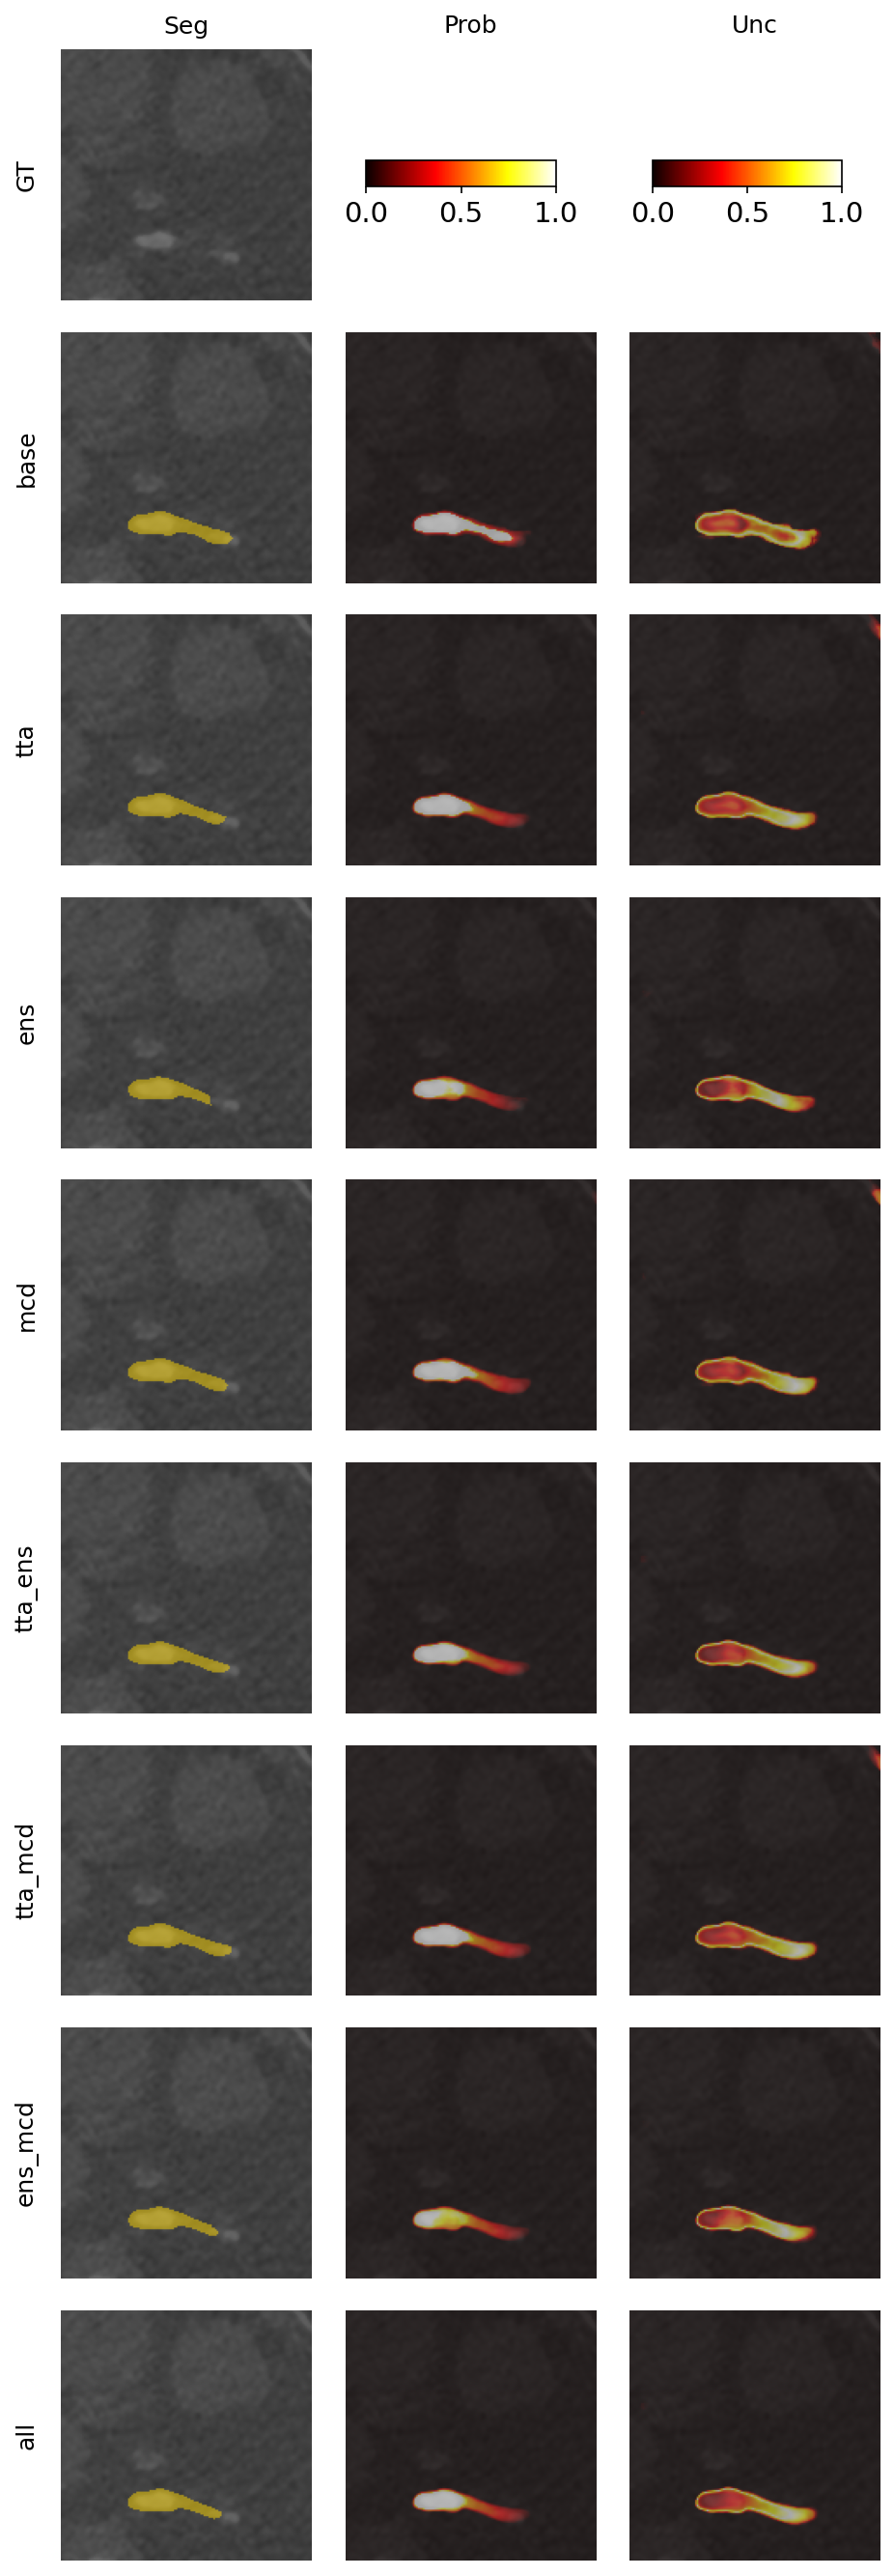

In [54]:
def plot_grid(image, gt, preds, prob_maps, unc_maps, model_names, slice_idx=None):
    if slice_idx is None:
        slice_idx = image.shape[2] // 2
    img = crop_center(normalize_image(image[:, :, slice_idx]))
    gt_slice = crop_center(gt[:, :, slice_idx])
    pred_slices = [crop_center(p[:, :, slice_idx]) for p in preds]
    prob_slices = [crop_center(p[:, :, slice_idx]) for p in prob_maps]
    unc_slices = [crop_center(u[:, :, slice_idx]) for u in unc_maps]

    n_rows = len(model_names) + 1  # models + label + ground truth
    n_cols = 4  # label, Seg, Prob, Unc
    fig, axes = plt.subplots(
        n_rows, n_cols, 
        figsize=(n_cols*1.6, n_rows*2),
        gridspec_kw={'width_ratios': [0.01, 1, 1, 1]}
    )
    fig.subplots_adjust(wspace=0.01, hspace=0.01)

    all_prob = np.concatenate([s.ravel() for s in prob_slices])
    all_unc  = np.concatenate([s.ravel() for s in unc_slices])
    prob_norm = plt.Normalize(all_prob.min(), all_prob.max())
    unc_norm  = plt.Normalize(all_unc.min(),  all_unc.max())
    # scalar mappables
    prob_sm = plt.cm.ScalarMappable(norm=prob_norm, cmap='hot')
    unc_sm  = plt.cm.ScalarMappable(norm=unc_norm,  cmap='hot')
    prob_sm._A = []; unc_sm._A = []

    # remove any existing header axes for prob/unc
    axes[0,2].axis('off')
    axes[0,3].axis('off')

    # place a slim horizontal colorbar above column 2
    pos2 = axes[0,2].get_position()
    cbax_prob = fig.add_axes([
        pos2.x0 + pos2.width*0.1,
        pos2.y0 + pos2.height*1.5,
        pos2.width*0.8,
        0.01
    ])
    cbar_prob = fig.colorbar(
        prob_sm,
        cax=cbax_prob,
        orientation='horizontal',
        ticks=[prob_norm.vmin,
               (prob_norm.vmin+prob_norm.vmax)/2,
               prob_norm.vmax]
    )
    cbar_prob.set_ticklabels([
        f"{prob_norm.vmin:.1f}",
        f"{(prob_norm.vmin+prob_norm.vmax)/2:.1f}",
        f"{prob_norm.vmax:.1f}"
    ])

    # place a slim vertical colorbar beside column 3
    pos3 = axes[0,3].get_position()
    cbax_unc = fig.add_axes([pos3.x0 + pos3.width*0.3, pos3.y0 + pos3.height*1.5, pos3.width*0.8, 0.01])
    fig.colorbar(unc_sm, cax=cbax_unc, orientation='horizontal')

    # Header row for column titles
    axes[0,0].axis('off')
    for j, title in enumerate(['Seg', 'Prob', 'Unc'], start=1):
        axes[0,j].set_title(title, pad=8, fontsize=12)
        axes[0,j].axis('off')

    # Ground truth row label and image
    axes[0,0].text(0.5, 0.5, 'GT', ha='center', va='center', rotation=90, fontsize=12)
    axes[0,1].imshow(overlay_segmentation(img, gt_slice)); axes[0,1].axis('off')
    axes[0,2].axis('off'); axes[0,3].axis('off')

    # Model rows
    for i, name in enumerate(model_names, start=1):
        axes[i,0].axis('off')
        axes[i,0].text(0.5, 0.5, name, ha='center', va='center', rotation=90, fontsize=12)
        axes[i,1].imshow(overlay_segmentation(img, pred_slices[i-1])); axes[i,1].axis('off')
        axes[i,2].imshow(overlay_heatmap(img, intensify_low_values(prob_slices[i-1]), cmap='hot')); axes[i,2].axis('off')
        axes[i,3].imshow(overlay_heatmap(img, intensify_low_values(unc_slices[i-1]), cmap='hot')); axes[i,3].axis('off')

    plt.tight_layout(); plt.show()

plot_grid(i, gt, preds, prob_maps, unc_maps, model_names, slice_idx=25) 

# plot_grid(i, gt, preds, prob_maps, unc_maps, model_names, slice_idx=197) # image case_0083 zoom=0.8 model_perf_id 
# plot_grid(i, gt, preds, prob_maps, unc_maps, model_names, slice_idx=25) # image case_0002 zoom=0.8 model_perf_ood
# plot_grid(i, gt, preds, prob_maps, unc_maps, model_names, slice_idx=25) # image case_0002 zoom=0.3 model_perf_ood_zoom

In [79]:
dataset = 'Dataset003_ImageCAS_split'





# List of model names (order will be used in the figure)
model_names = ["mcd", "tta_mcd", "ens_mcd", "all"]

model_paths = [join('nnUNetTrainerDropout__p02_s2__3d_fullres', model_name) for model_name in model_names]

cases = find_cases(join(nnUNet_results, dataset, model_paths[0]))  # Assuming all models have the same cases

case = cases[0]  # Select the first case for demonstration

case = 'case_0002'

# Example: one case, 8 models
image_path = join(nnUNet_raw, dataset, 'imagesTs', f'{case}_0000.nii.gz')
gt_path = join(nnUNet_raw, dataset, 'labelsTs', f'{case}.nii.gz')

# For each model, provide prediction, probability, and uncertainty map paths
model_pred_paths = [join(nnUNet_results, dataset, model_path, case, f'{case}_seg.nii.gz') for model_path in model_paths]
model_prob_paths = [join(nnUNet_results, dataset, model_path, case, f'{case}_foreground.nii.gz') for model_path in model_paths]
model_entropy_paths = [join(nnUNet_results, dataset, model_path, case, f'{case}_shannon_entropy.nii.gz') for model_path in model_paths]
model_exp_entropy_paths = [join(nnUNet_results, dataset, model_path, case, f'{case}_expected_entropy.nii.gz') for model_path in model_paths]
model_mutual_info_paths = [join(nnUNet_results, dataset, model_path, case, f'{case}_mutual_info.nii.gz') for model_path in model_paths]
model_variance_paths = [join(nnUNet_results, dataset, model_path, case, f'{case}_variance.nii.gz') for model_path in model_paths]


i = load_nii(image_path)
gt = load_nii(gt_path)
preds = [load_nii(p) for p in model_pred_paths]
prob_maps = [load_nii(p) for p in model_prob_paths]
ent_maps = [load_nii(u) for u in model_entropy_paths]
exp_ent_maps = [load_nii(u) for u in model_exp_entropy_paths]
mutual_info_maps = [load_nii(u) for u in model_mutual_info_paths]



/tmp/ipykernel_587285/2731382245.py:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(); plt.show()


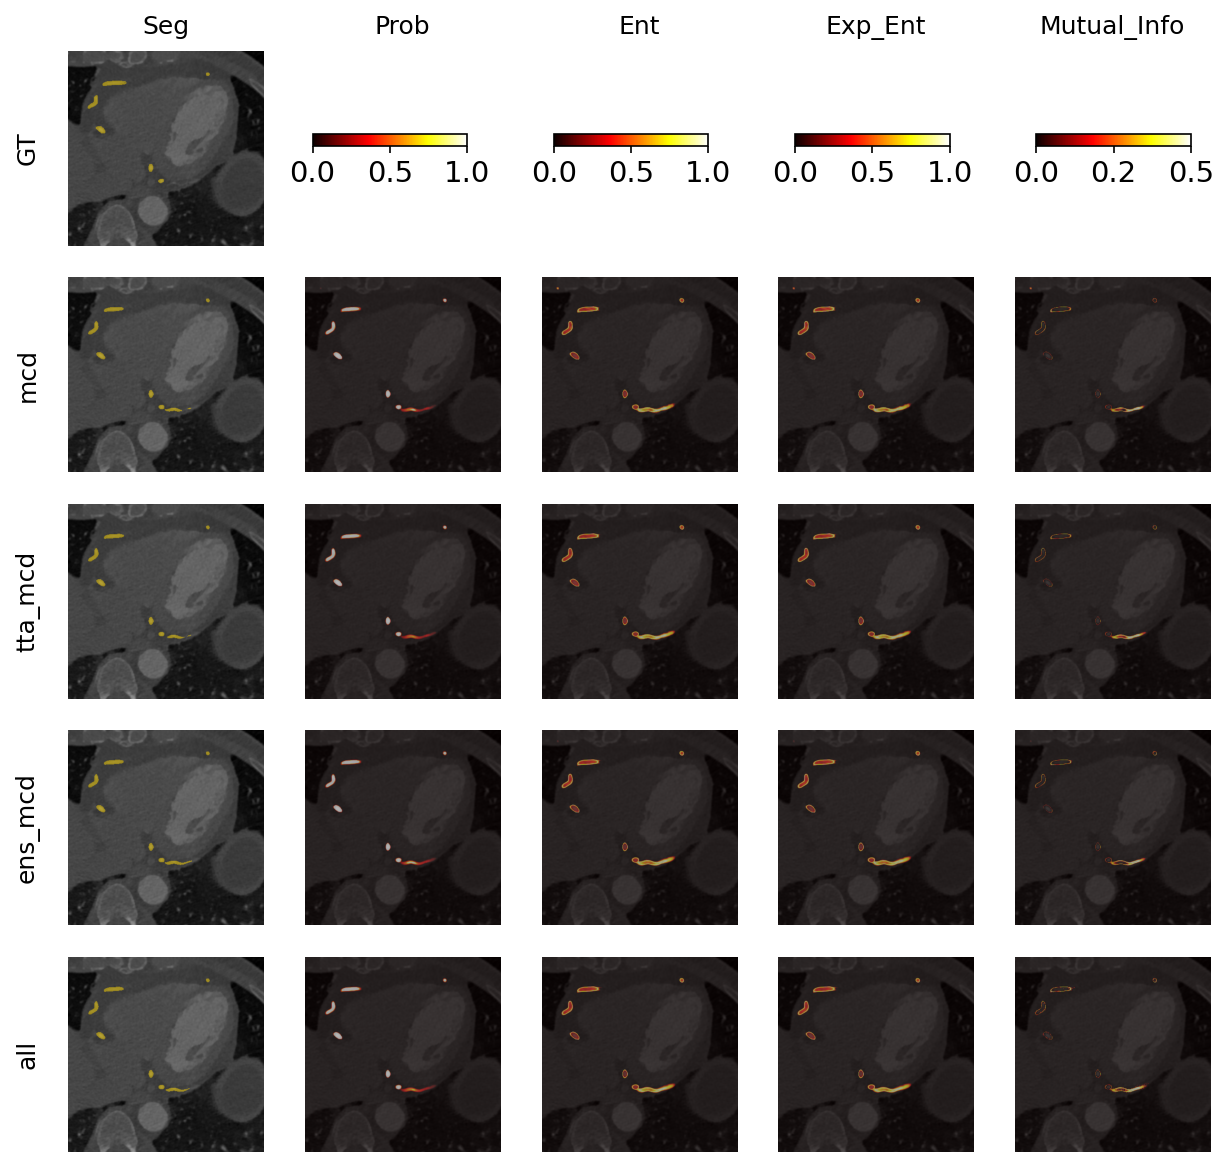

In [ ]:
def plot_grid(image, gt, preds, prob_maps, ent_maps, exp_ent_maps, mutual_info_maps, model_names, slice_idx=None):
    if slice_idx is None:
        slice_idx = image.shape[2] // 2
    img = crop_center(normalize_image(image[:, :, slice_idx]))
    gt_slice = crop_center(gt[:, :, slice_idx])
    pred_slices = [crop_center(p[:, :, slice_idx]) for p in preds]
    prob_slices = [crop_center(p[:, :, slice_idx]) for p in prob_maps]
    ent_slices = [crop_center(u[:, :, slice_idx]) for u in ent_maps]
    exp_ent_slices = [crop_center(u[:, :, slice_idx]) for u in exp_ent_maps]
    mutual_info_slices = [crop_center(u[:, :, slice_idx]) for u in mutual_info_maps]

    n_rows = len(model_names) + 1  # ground truth + models
    n_cols = 6  # label, Seg, Prob, Ent, Exp_Ent, Mutual_Info
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*1.4, n_rows*1.6),
                             gridspec_kw={'width_ratios': [0.01, 0.9, 0.9, 0.9, 0.9, 0.9]})
    fig.subplots_adjust(wspace=0.01, hspace=0.01)

    

    # Header row for column titles
    axes[0,0].axis('off')
    for j, title in enumerate(['Seg', 'Prob', 'Ent', 'Exp_Ent', 'Mutual_Info'], start=1):
        axes[0,j].set_title(title, pad=8, fontsize=12)
        axes[0,j].axis('off')

    # Ground truth row label and image
    axes[0,0].text(0.5, 0.5, 'GT', ha='center', va='center', rotation=90, fontsize=12)
    axes[0,1].imshow(overlay_segmentation(img, gt_slice)); axes[0,1].axis('off')
    axes[0,2].axis('off'); axes[0,3].axis('off')

    all_prob = np.concatenate([s.ravel() for s in prob_slices])
    all_unc  = np.concatenate([s.ravel() for s in ent_slices])
    all_exp_ent = np.concatenate([s.ravel() for s in exp_ent_slices])
    all_mutual_info = np.concatenate([s.ravel() for s in mutual_info_slices])
    # Normalize all maps for color scaling
    prob_norm = plt.Normalize(all_prob.min(), all_prob.max())
    unc_norm  = plt.Normalize(all_unc.min(),  all_unc.max())
    exp_ent_norm = plt.Normalize(all_exp_ent.min(),  all_exp_ent.max())
    mutual_info_norm = plt.Normalize(all_mutual_info.min(),  all_mutual_info.max())
    # scalar mappables
    prob_sm = plt.cm.ScalarMappable(norm=prob_norm, cmap='hot')
    unc_sm  = plt.cm.ScalarMappable(norm=unc_norm,  cmap='hot')
    exp_ent_sm = plt.cm.ScalarMappable(norm=exp_ent_norm, cmap='hot')
    mutual_info_sm = plt.cm.ScalarMappable(norm=mutual_info_norm, cmap='hot')
    prob_sm._A = []; unc_sm._A = []; exp_ent_sm._A = []; mutual_info_sm._A = []

    # remove any existing header axes for prob/unc
    axes[0,2].axis('off')
    axes[0,3].axis('off')

    for j in range(2, 6):
        axes[0,j].axis('off')
        # place a slim horizontal colorbar above each column
        pos = axes[0,j].get_position()
        cbax = fig.add_axes([
            pos.x0 + pos.width*0.24*(j-3) + pos.width*0.1,
            pos.y0 + pos.height*0.9,
            pos.width*0.8,
            0.01
        ])
        if j == 2:
            cbar = fig.colorbar(prob_sm, cax=cbax, orientation='horizontal', ticks=[prob_norm.vmin, (prob_norm.vmin+prob_norm.vmax)/2, prob_norm.vmax])
            cbar.set_ticklabels([
                f"{prob_norm.vmin:.1f}",
                f"{(prob_norm.vmin+prob_norm.vmax)/2:.1f}",
                f"{prob_norm.vmax:.1f}"
            ])
        elif j == 3:
            cbar = fig.colorbar(unc_sm, cax=cbax, orientation='horizontal', ticks=[unc_norm.vmin, (unc_norm.vmin+unc_norm.vmax)/2, unc_norm.vmax])
            cbar.set_ticklabels([
                f"{-unc_norm.vmin:.1f}",
                f"{(unc_norm.vmin+unc_norm.vmax)/2:.1f}",
                f"{unc_norm.vmax:.1f}"
            ])
        elif j == 4:
            cbar = fig.colorbar(exp_ent_sm, cax=cbax, orientation='horizontal', ticks=[exp_ent_norm.vmin, (exp_ent_norm.vmin+exp_ent_norm.vmax)/2, exp_ent_norm.vmax])
            cbar.set_ticklabels([
                f"{exp_ent_norm.vmin:.1f}",
                f"{(exp_ent_norm.vmin+exp_ent_norm.vmax)/2:.1f}",
                f"{exp_ent_norm.vmax:.1f}"
            ])
        elif j == 5:
            cbar = fig.colorbar(mutual_info_sm, cax=cbax, orientation='horizontal', ticks=[mutual_info_norm.vmin, (mutual_info_norm.vmin+mutual_info_norm.vmax)/2, mutual_info_norm.vmax])
            cbar.set_ticklabels([
                f"{mutual_info_norm.vmin:.1f}",
                f"{(mutual_info_norm.vmin+mutual_info_norm.vmax)/2:.1f}",
                f"{mutual_info_norm.vmax:.1f}"
            ])

    

    # Model rows
    for i, name in enumerate(model_names, start=1):
        axes[i,0].axis('off')
        axes[i,0].text(0.5, 0.5, name, ha='center', va='center', rotation=90, fontsize=12)
        axes[i,1].imshow(overlay_segmentation(img, pred_slices[i-1])); axes[i,1].axis('off')
        axes[i,2].imshow(overlay_heatmap(img, intensify_low_values(prob_slices[i-1]), cmap='hot')); axes[i,2].axis('off')
        axes[i,3].imshow(overlay_heatmap(img, intensify_low_values(ent_slices[i-1]), cmap='hot')); axes[i,3].axis('off')
        axes[i,4].imshow(overlay_heatmap(img, intensify_low_values(exp_ent_slices[i-1]), cmap='hot')); axes[i,4].axis('off')
        axes[i,5].imshow(overlay_heatmap(img, intensify_low_values(mutual_info_slices[i-1]), cmap='hot')); axes[i,5].axis('off')

    plt.tight_layout(); plt.show()

# plot_grid(i, gt, preds, prob_maps, ent_maps, exp_ent_maps, mutual_info_maps, model_names, slice_idx=25) case_0002 zoom=0.3 model_perf_uq_ood_zoom
# plot_grid(i, gt, preds, prob_maps, ent_maps, exp_ent_maps, mutual_info_maps, model_names, slice_idx=133) # case_0002 zoom=0.8 model_perf_uq_id
# plot_grid(i, gt, preds, prob_maps, ent_maps, exp_ent_maps, mutual_info_maps, model_names, slice_idx=2) # case_0002 zoom=0.8 model_perf_uq_ood
plot_grid(i, gt, preds, prob_maps, ent_maps, exp_ent_maps, mutual_info_maps, model_names, slice_idx=133)